In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.src.layers import Dense
from keras.src.layers import LSTM, Dropout
from keras.src.optimizers import Adam
from keras.src.callbacks import ModelCheckpoint, EarlyStopping
import math
from sklearn.metrics import mean_squared_error
import datetime
import mplfinance as mpf
import math 
import os

In [3]:
df = pd.read_csv('/Users/leo/Desktop/Invest_hub/data/historical_data/VKCO_1d.csv')



In [148]:
def str_to_datetime(s):
    date_part, time_part = s.split(' ')[0], s.split(' ')[1].split('+')[0]
    
    year, month, day = map(int, date_part.split('-'))
    hour, _, _ = map(int, time_part.split(':'))
    
    return datetime.datetime(year=year, month=month, day=day, hour=hour, minute=0, second=0)
df['Time'] = df['Time'].apply(str_to_datetime)

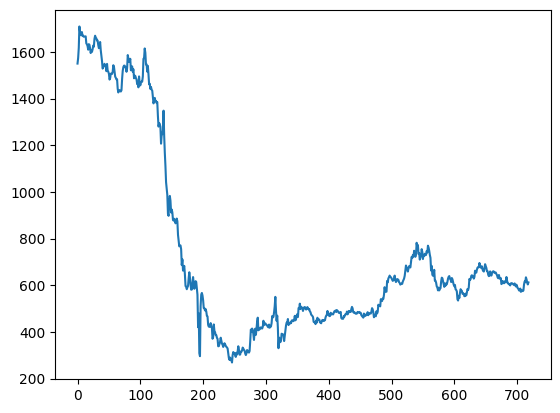

In [149]:
plt.plot(df.index, df['Close'])

In [150]:
def specific_data(start, end):
    data = df
    filtered_data = data[(data['Time'] >= start) & (data['Time'] <= end)]
    return filtered_data

In [151]:
start_time= '2022-12-14 00:00:00'
end_time='2024-04-23 00:00:00'

spec_df = specific_data(start_time, end_time)
print(spec_df.head())
print(f"Total data points: {len(spec_df)}")


          Time   Open   High    Low  Close   Volume
376 2022-12-14  465.0  465.0  438.4  443.0   979518
377 2022-12-15  442.0  448.0  428.0  441.2  1089337
378 2022-12-16  441.2  446.8  438.0  442.6   313857
379 2022-12-19  443.0  443.4  428.0  433.4   762319
380 2022-12-20  430.0  452.2  428.8  449.4   830083
Total data points: 322


In [152]:
new_df = spec_df['Close'].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(new_df.reshape(-1, 1))
print(f"Scaled data shape: {scaled_data.shape}")

Scaled data shape: (322, 1)


In [153]:
train_size = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")



Train data shape: (225, 1)
Test data shape: (97, 1)


In [154]:
n_past = 50

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

print("Before reshape - X_train shape:", X_train.shape)
print("Before reshape - X_test shape:", X_test.shape)
if X_test.shape[0] > 0:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
else:
    print("Insufficient data for testing. Adjust the train/test split or provide more data.")

Training set size: (175, 50) (175,)
Testing set size: (47, 50) (47,)
Before reshape - X_train shape: (175, 50)
Before reshape - X_test shape: (47, 50)


In [155]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 989,573 (3.77 MB)

 Trainable params: 329,857 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 659,716 (2.52 MB)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0059 - val_loss: 0.0018
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0060 - val_loss: 0.0012
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0060 - val_loss: 0.0037
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0070 - val_loss: 0.0012
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0073 - val_l

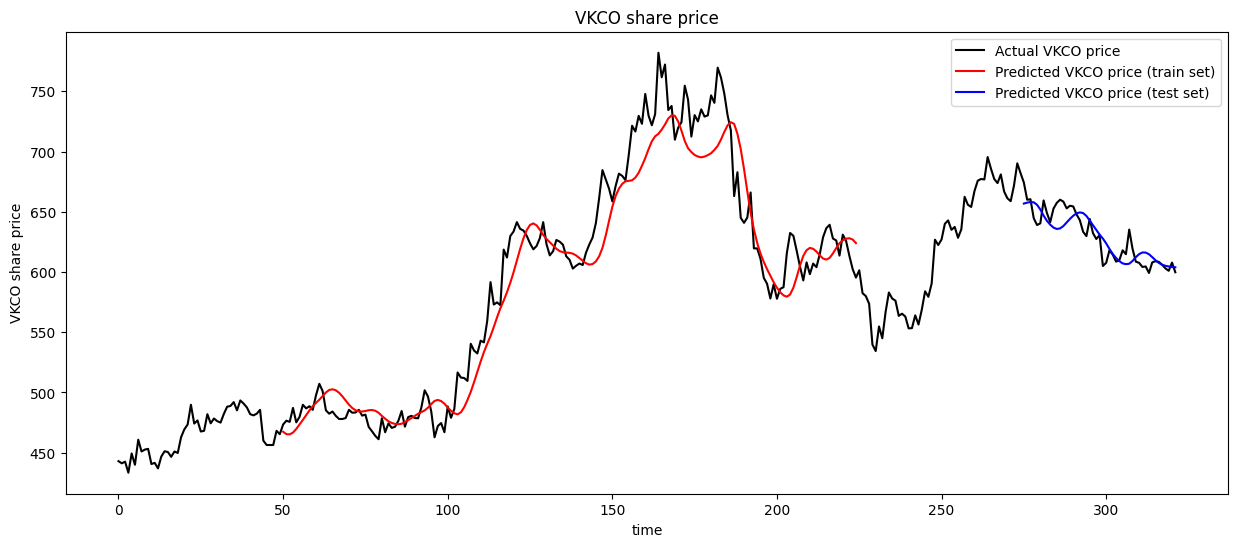

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [158]:
checkpoints = ModelCheckpoint(filepath='my_weights.keras', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.summary()

if X_test.shape[0] > 0:
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[checkpoints, early_stopping])

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    print(math.sqrt(mean_squared_error(y_train, train_predict)))
    print(math.sqrt(mean_squared_error(y_test, test_predict)))

    file_name = "VKCO_1d.csv"
    company_name = os.path.basename(file_name).split('_')[0]

    trainPredictPlot = np.empty_like(new_df)
    trainPredictPlot[:] = np.nan
    trainPredictPlot[n_past:len(train_predict) + n_past] = train_predict.flatten()

    testPredictPlot = np.empty_like(new_df)
    testPredictPlot[:] = np.nan
    test_start = len(new_df) - len(test_predict)
    testPredictPlot[test_start:] = test_predict.flatten()

    original_scaled_data = scaler.inverse_transform(scaled_data)

    plt.figure(figsize=(15, 6))
    plt.plot(original_scaled_data, color='black', label=f"Actual {company_name} price")
    plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_name} price (train set)")
    plt.plot(testPredictPlot, color='blue', label=f"Predicted {company_name} price (test set)")
    plt.title(f"{company_name} share price")
    plt.xlabel("time")
    plt.ylabel(f"{company_name} share price")
    plt.legend()
    plt.show()

    last_sequence = X_test[-1]
    last_sequence = last_sequence.reshape(1, n_past, 1)

    predictions_next_30_days = []
    for _ in range(30):
        next_day_prediction = model.predict(last_sequence)
        predictions_next_30_days.append(next_day_prediction[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = next_day_prediction

    predictions_next_30_days = scaler.inverse_transform(np.array(predictions_next_30_days).reshape(-1, 1))

    print("Predictions for the next 30 days:")
    for i, prediction in enumerate(predictions_next_30_days, start=1):
        print(f"Day {i}: Predicted Price = {prediction[0]}")

    predicted_dates = pd.date_range(start=spec_df['Time'].iloc[-1] + pd.Timedelta(days=1), periods=30, freq='D')

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Time'], y=df['Close'], mode='lines', name='Closing Price', line=dict(width=2)))
    fig.add_trace(go.Scatter(x=predicted_dates, y=predictions_next_30_days.flatten(), mode='lines+markers', name='Predicted Prices (Next 30 Days)', line=dict(color='blue')))
    fig.update_layout(title='Actual and Predicted Stock Prices for the Next 30 Days', xaxis_title='Date', yaxis_title='Price', xaxis=dict(tickformat='%Y-%m-%d', tickangle=45), legend=dict(x=0, y=1), template='plotly_white')
    fig.show()
else:
    print("Not enough test data to proceed with model training and prediction.")

In [53]:
fig = px.line(spec_df, x='Time', y='Close', title='Closing Prices Over Time')
fig.update_layout(xaxis_title='Date', yaxis_title='Closing price', xaxis=dict(tickformat='%Y-%m-%d', tickangle=45))
fig.show()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [54]:
fig = go.Figure(data=[go.Candlestick(x=spec_df['Time'], open=spec_df['Open'], high=spec_df['High'], low=spec_df['Low'], close=spec_df['Close'])])
fig.update_layout(title='Candlestick Chart', xaxis_title='Date', yaxis_title='Price', xaxis=dict(tickformat='%Y-%m-%d', tickangle=45), template='plotly_white')
fig.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [55]:
window_days = 1
spec_df['1-Day Moving Avg'] = spec_df['Close'].rolling(window=window_days).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=spec_df['Time'], y=spec_df['Close'], mode='lines', name='Closing Price', line=dict(width=2)))
fig.add_trace(go.Scatter(x=spec_df['Time'], y=spec_df['1-Day Moving Avg'], mode='lines', name='1-Day Moving Avg', line=dict(dash='dash')))
fig.update_layout(title='Closing Prices and 1-Day Moving Average', xaxis_title='Date', yaxis_title='Price', xaxis=dict(tickformat='%Y-%m-%d %H:%M:%S', tickangle=45), legend=dict(x=0, y=1), template='plotly_white')
fig.show()

/var/folders/f0/zwtts9w11p52b78sr6n20nwc0000gn/T/ipykernel_21837/2585761482.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [56]:
spec_df['Month'] = spec_df['Time'].dt.month
monthly_average = spec_df.groupby('Month')['Close'].mean().reset_index()

fig = px.line(monthly_average, x='Month', y='Close', markers=True, title='Monthly Seasonality of Closing Prices')
fig.update_layout(xaxis_title='Months', yaxis_title='Average Closing Price', xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']), template='plotly_white')
fig.show()


/var/folders/f0/zwtts9w11p52b78sr6n20nwc0000gn/T/ipykernel_21837/3626072944.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
new_df = spec_df.reset_index()['Close']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1, 1))
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
n_past = 100

In [57]:
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [58]:
print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

print("Before reshape - X_train shape:", X_train.shape)
print("Before reshape - X_test shape:", X_test.shape)

if X_test.shape[0] > 0:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
else:
    print("Insufficient data for testing. Adjust the train/test split or provide more data.")


Training set size: (180, 100) (180,)
Testing set size: (0,) (0,)
Before reshape - X_train shape: (180, 100)
Before reshape - X_test shape: (0,)
Insufficient data for testing. Adjust the train/test split or provide more data.


In [41]:
print("Before reshape - X_train shape:", X_train.shape)
print("Before reshape - X_test shape:", X_test.shape)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Before reshape - X_train shape: (180, 100)
Before reshape - X_test shape: (0,)


IndexError: tuple index out of range